# Tutorial for PsPolypy

## Imports

In [1]:
# Import necessary libraries for this example
import numpy as np
from skimage import io

from IPython.display import display, Math

# Locate PsPolypy. Only necessary if PsPolypy is not installed as a package.
import sys
sys.path.append('../src/')

# Import PsPolypy
import  PsPolypy

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
from cycler import cycler

# rcParams settings

plt.rcParams['axes.prop_cycle'] = cycler(color='krbmgcy')

plt.rcParams['axes.linewidth'] = 1.5

plt.rcParams['xtick.top'] = plt.rcParams['ytick.right'] = True
plt.rcParams['xtick.minor.visible'] = plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['xtick.direction'] = plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = plt.rcParams['ytick.major.size'] = 8 
plt.rcParams['xtick.minor.size'] = plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['xtick.major.width'] = plt.rcParams['ytick.major.width'] = 1; 
plt.rcParams['savefig.bbox']='tight'
plt.rcParams['savefig.transparent']=True

plt.rcParams['legend.framealpha'] = 0.6
plt.rcParams['legend.markerscale'] = 2.
plt.rcParams['legend.fontsize'] = 'xx-large'
plt.rcParams['figure.subplot.wspace'] = 0.02
plt.rcParams['figure.subplot.hspace'] = 0.02
plt.rcParams['axes.labelpad'] = 5.
plt.rcParams['figure.dpi'] = 300

plt.rcParams['xtick.labelsize'] = plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['axes.labelsize'] = 24
plt.rcParams['figure.figsize'] = (8, 6)

plt.rcParams["font.family"]='serif'
plt.rcParams["mathtext.fontset"]='stix';

## Step-By-Step Workflow

### Create an instance of Polydat

There are three means of creating an instance of the ```Polydat``` class. ```from_images``` for creates an instance of ```Polydat``` from a list of image files. An empty ```Polydat``` instance can be created, and images can be added with the ```add_image``` method. Finally, a list of images can be passed to the built-in initialization function for ```polydat```. These options are shown below.

In [3]:
# Create an instance of the Polydat class from a single image. Note, it must be a list of file paths, even if there is only one image.
image_path = ['example_images/exampleCL0.png']
polydat = PsPolypy.Polymer.Polydat.from_images(image_path, resolution = 2)
# Check that the polydat object has been created correctly.
print(f'The first polydat object contains {len(polydat.images)} image(s).')

# Example of creating an instance of the Polydat class from a list of image file paths.
image_paths = ['example_images/exampleCL0.png', 'example_images/exampleCL1.png']
polydat = PsPolypy.Polymer.Polydat.from_images(image_paths, resolution = 2)
# Check that the polydat object has been created correctly.
print(f'The second polydat object contains {len(polydat.images)} image(s).')

The first polydat object contains 1 image(s).
The second polydat object contains 2 image(s).


In [4]:
# Create an empty instance of the Polydat class and add an image to it.
polydat = PsPolypy.Polymer.Polydat()
polydat.add_image('example_images/exampleCL0.png', resolution = 2)
polydat.add_image('example_images/exampleCL1.png', resolution = 2)
# Check that the polydat object has been created correctly.
print(f'The polydat object contains {len(polydat.images)} image(s).')

The polydat object contains 2 image(s).


In [5]:
# Create an instance of the Polydat class from a list of numpy arrays.
filepath = 'example_images/exampleCL0.png'
image = io.imread(filepath, as_gray = True)
polydat = PsPolypy.Polymer.Polydat([image], resolution = 2)
# Check that the polydat object has been created correctly.
print(f'The polydat object contains {len(polydat.images)} image(s).')

The polydat object contains 1 image(s).


### Upscaling images with Polydat

The first method for processing the image(s) is to (optionally) upscale them. ```upscale``` takes two arguments, ```magnification``` (int/float) and ```order``` (int). Each image has its shape multiplied by the ```magnification``` factor and interpolated by a 2D spline of ```order``` power. The upscaled image is set set back in the ```images``` attribute, i.e. this operation occurs in place. Furthermore, the ```resolution``` attribute is dynamically updated to reflect the new nm/px value. 

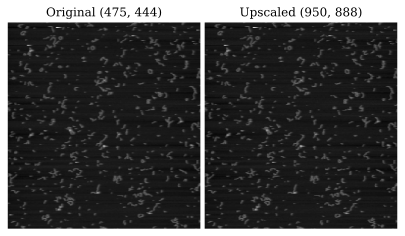

In [6]:
# Create an instance of the Polydat class from the test image.
image_path = ['example_images/exampleCL0.png']
polydat = PsPolypy.Polymer.Polydat.from_images(image_path, resolution = 2)
# Extract the image from the polydat object.
base_image = polydat.images[0]

# Upscale the image by a factor of 2 using bi-cubic interpolation.
polydat.upscale(magnification = 2, order = 3)
# Extract the upscaled image from the polydat object.
upscaled_image = polydat.images[0]

# Plot the original and upscaled images for comparison.
fig, ax = plt.subplots(1,2, figsize = (7,6))
for axis in ax:
    axis.axis('off')

# Display the images.
ax[0].imshow(base_image, cmap = 'gray')
ax[0].set_title(f'Original {base_image.shape}')
ax[1].imshow(upscaled_image, cmap = 'gray')
ax[1].set_title(f'Upscaled {upscaled_image.shape}')

# Display the plot.
plt.show()

### Segment the Particles

```segment_particles``` segments the images in the ```polydat``` instance. This method takes two optional arguments: ```minimum_area``` (int) and ```padding``` (int). During segmentation, any particle whose area is less than ```minimum_area``` is discarded. ```padding``` indicates how many padding pixels to include around the cropped region surrounding each particle.

In [7]:
# Segment the particles in the image.
polydat.segment_particles()

# Check to see how many particles were detected.
print(f'The polydat object detected and segmented {polydat.num_particles} particles.')

The polydat object detected and segmented {'All': 416, 'Linear': 0, 'Branched': 0, 'Looped': 0, 'Branched-Looped': 0, 'Overlapped': 0, 'Unknown': 0} particles.


The segmented particles can be visualized with ```plot_particle```. It takes the argument ```index``` for which particle to plot.

**Note:** All plotting functions take the optional argument ```ax``` which chooses the ```matplotlib.pyplot.axis``` to draw to. If not explicitly specified, the current axis is selected with ```matplotlib.pyplot.gca```. For more information, see the Matplotlib documentation [here](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.gca.html).

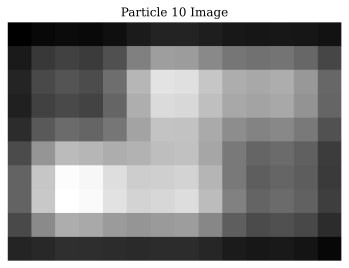

In [8]:
# Select which particle to view the image of.
particle_index = 10

# Create the figure and the axis for the particle image.
particle_fig, ax = plt.subplots(figsize = (6,6))
# Plot the image to the axis.
polydat.plot_particle(particle_index, ax, cmap = 'gray')
# Set the title of the plot.
ax.set_title(f'Particle {particle_index} Image')
# Turn the axis off
ax.axis('off')
# Display the plot.
plt.show()

### Skeletonize the Particles

The ```skeletoinize_particles``` method creates skan skeleton representations of each ```particle```. This occurs in place, and sets the ```Particle.skeleton``` attribute of each particle in the ```Polydat.particles``` list.

In [9]:
# Skeletonize the particles with the default parameters.
skeletonized_particles = polydat.skeletonize_particles()

The skeletons can be visualized with ```plot_skeleton```. It takes the argument ```index``` for which skeleton to plot, as well as ```**kwargs``` passed to ```matplotlib.imshow```.

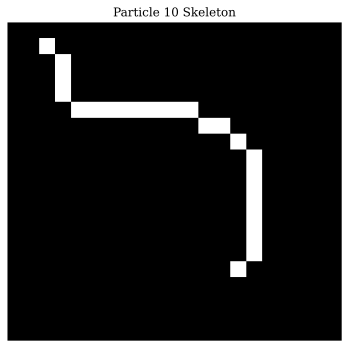

In [10]:
# Select which particle to view the skeleton of.
particle_index = 10

# Create the figure and the axis for the skeleton image.
skeleton_fig1, ax = plt.subplots(figsize = (6,6))
# Plot the skeleton image to the axis.
ax = polydat.plot_skeleton(particle_index, cmap = 'gray')
# Set the title of the plot.
ax.set_title(f'Particle {particle_index} Skeleton')
# Turn the axis off
ax.axis('off')
# Display the plot.
plt.show()

```interpolate_skeletons``` interpolates each particle skeleton along the contur in a user defined ```step_size``` (float). ```step_size``` can be set below 1 to sample the contour above the current pixel resolution. The optional arguments for the interpolation order ```k``` (int) and smoothing ```s``` (float) are passed to ```scipy.interpolate.splprep```. For more information see the scipy documentation [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.splprep.html#scipy.interpolate.splprep).

```plot_interpolated_skeleton``` will now display the interpolated skeleton contour.

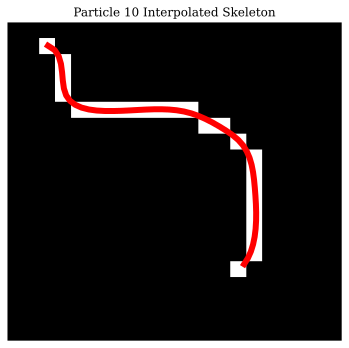

In [11]:
# Interpolate the skeletons of the particles.
polydat.interpolate_skeletons(step_size = 0.5, k = 3, s = 0.5)

# Select which particle to view the interpolated skeleton of.
particle_index = 10

# Create the figure and the axis for the skeleton image.
skeleton_fig2, ax = plt.subplots(figsize = (6,6))
# Plot the skeleton image to the axis.
polydat.plot_skeleton(particle_index, ax, cmap = 'gray',alpha=1)
# Plot the interpolated skeleton to the axis.
polydat.plot_interpolated_skeleton(particle_index, ax, lw = 6, color = 'red')
# Set the title of the plot.
ax.set_title(f'Particle {particle_index} Interpolated Skeleton')
# Turn the axis off
ax.axis('off')
# Display the plot.
plt.show()

```plot_contour_distribution``` plots a distribution of all particle contour lengths. This plotting takes in ```Dict```s of keyword arguments passed to matplotlib. The kwargs for controling the plot are ```inc_dist_kwargs``` and ```inc_fill_kwargs``` for the distribtuion and fill respectively. See the docstring for more information.

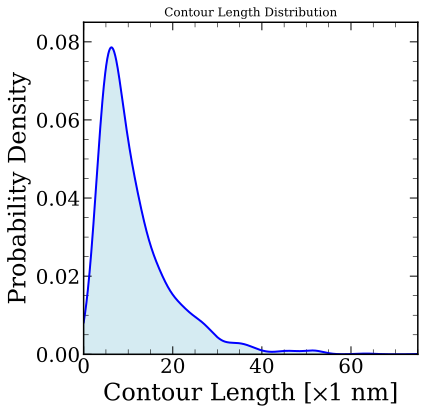

In [12]:
# Create the figure and the axis for the contour distribution.
contour_distribution_fig1, ax = plt.subplots(figsize = (6,6))

# Plot the contour length distribution.
ax = polydat.plot_contour_distribution(n_points = 1000,
                                       inc_dist_kwargs = {'color': 'Blue', 'lw': 2,},
                                       inc_fill_kwargs = {'color': 'LightBlue', 'alpha': 0.5})
# Set the title of the plot.
ax.set_title('Contour Length Distribution')
# Set the axis labels.
ax.set_xlabel(fr'Contour Length [$\times${polydat.resolution:.0f} nm]')
ax.set_ylabel('Probability Density')
# Set the axis limits.
ax.set_ylim([0,0.085])
ax.set_xlim([0,75])
plt.show()

### Classifying The Particles

```classify_particles``` sets the ```classification``` attribute of each particle. Each particle is classified by the following criteria:
- If the particle contains a single branch path with two different endpoints, the particle is classified as ```Linear```.
- If the particle contains a single branch path with the same end points, the particle is classified as ```Looped```.
- If the particle contains multiple branch paths that intersect at a branch point but no cycles (A point can be revisited when traveling along a set of branch paths), the particle is classified as ```Branched```.
- If the particle contains multiple branch paths that intersect at a branch point and includes cycles, the particle is classified as ```Brached-Looped```.
- If the particle contains a branch point of order 4 or greater whose real-space height is > 1.5 times the mean height of the skeleton's height, the particle is classified as ```Overlapped```.
- If none of the above criteria are met, the particle is classified as ```Unknown```. This should not occur, but is included for safety.

```filter_particles``` takes the argument ```classifications``` (list[str]). This removes all particles from the ```polydat``` instance whose classification is not in the list.

The number of linear particles is 225.


(np.float64(-0.5), np.float64(11.5), np.float64(15.5), np.float64(-0.5))

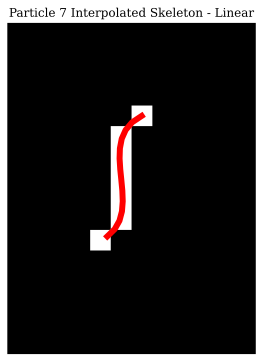

In [13]:
# Classify the Particles
polydat.classify_particles()

# Get the number of particles in the Linear classification.
linear_particles = [particle for particle in polydat.particles if particle.classification == 'Linear']
print(f'The number of linear particles is {len(linear_particles)}.')

# Select the first particle in the Linear classification.
particle = linear_particles[0]

# Create the figure and the axis for the particle image.
linear_skeleton_fig, ax = plt.subplots(figsize = (6,6))
# Plot the first particle's skeleton.
ax = particle.plot_skeleton(cmap = 'gray')
# Plot the first particle's interpolated skeleton.
ax = particle.plot_interpolated_skeleton(lw = 6, color = 'red')
# Set the title of the plot.
ax.set_title(f'Particle {particle.id} Interpolated Skeleton - {particle.classification}')
# Turn the axis off
ax.axis('off')

### Calculating the Persistence Length

```calc_tantan_correlations``` calculates the Tangent-Tangent correlation for all pairs of points in all paths. The correlations are averaged for each contour length and ```mean_tantan_correlation``` is set.

```plot_mean_tantan_correlation``` creates a plot of the mean Tangent-Tangent correlation. It takes a single optional argument ```error_bars``` (bool) to turn error bars on and off. Furthermore, the plotting function includes keyword argument dictionaries ```inc_kwargs``` and ```exc_kwargs``` for altering the color of the correlation, its errorbars, etc. See the source code for more information.

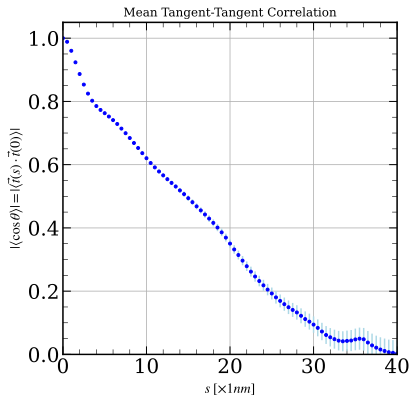

In [14]:
# Calculate the tangent-tangent correlation functions for all the particles.
polydat.calc_tantan_correlations()

tantan_correlation_fig1, ax = plt.subplots(figsize = (6,6))
# Plot the mean tangent-tangent correlation function.
polydat.plot_mean_tantan_correlations(error_bars = True,
                                          inc_kwargs = {'color': 'Blue', 'fmt': '.', 'ecolor': 'LightBlue'},
                                          exc_kwargs = {'color': 'Gray', 'fmt': '.', 'ecolor': 'LightGray'})
# Set the title of the plot.
ax.set_title('Mean Tangent-Tangent Correlation')
# Set the axis labels.
ax.set_xlabel(fr'$s\; [\times{polydat.resolution:.0f} nm]$',fontsize=14)
ax.set_ylabel(r'$|\langle\cos\theta\rangle|=|\langle\vec{t}(s)\cdot\vec{t}(0)\rangle|$',fontsize=14)
# Set the axis limits.
ax.set_xlim(0,40)
ax.set_ylim(0,1.05)
# Turn the grid on.
ax.grid()
# Display the plot.
plt.show()

```plot_subpath_contour_distribution``` plots a distribution of all particle subpath contour lengths. This plotting takes in ```Dict```s of keyword arguments passed to matplotlib. The kwargs for controling the plot are ```inc_dist_kwargs``` and ```inc_fill_kwargs``` for the distribtuion and fill respectively. See the docstring for more information.

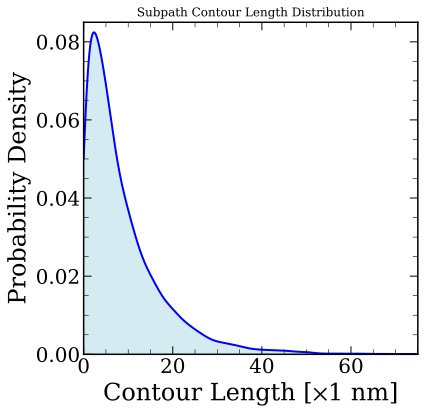

In [15]:
# Create the figure and the axis for the contour distribution.
subpath_contour_distribution_fig, ax = plt.subplots(figsize = (6,6))

# Plot the contour length distribution.
ax = polydat.plot_subpath_contour_distribution(n_points = 1000,
                                               inc_dist_kwargs = {'color': 'Blue', 'lw': 2,},
                                               inc_fill_kwargs = {'color': 'LightBlue', 'alpha': 0.5})
# Set the title of the plot.
ax.set_title('Subpath Contour Length Distribution')
# Set the axis labels.
ax.set_xlabel(fr'Contour Length [$\times${polydat.resolution:.0f} nm]')
ax.set_ylabel('Probability Density')
# Set the axis limits.
ax.set_ylim([0,0.085])
ax.set_xlim([0,75])
plt.show()

```calc_tantan_lp``` fits the mean Tangent-Tangent correlation to calculate the persistence length. It accepts two optional arguments, ```min_fitting_length``` (float) and ```max_fitting_length``` (float). Because the correlation contribution from low contour lengths can bias the fit, and the sampling of very long contour lengths is very low, the decaying exponential is only fit between these two values. Executing ```calc_tantan_lp``` sets the ```tantan_fit_result``` parmeter with a ```lmfit.model.ModelResult```. For more information about the result see the documentation [here](https://lmfit.github.io/lmfit-py/model.html#lmfit.model.ModelResult).

```print_summary``` prints a summary of the analysis performed. ```plot_mean_tantan_correlation_fit``` plots the fitted exponential. If the ```show_init``` argument is ```True```, the initial guess at the fit is shown along side the best fit. The ```init_kwargs``` can be set to adjust the parameters of the initial guess plot.

Polymer Data Summary
----------------------------------------------------------------
Image Summary:
Number of Images:			1
Base Resolution:			2.0 nm/pixel
Upscaled:				True
Magnification Factor:			2.0
Interploation Order:			3
Upscaled Resolution:			1.0 nm/pixel
----------------------------------------------------------------
Segmentation/Classification Summary:
All Particles:				416
Linear Particles:			225
Branched Particles:			103
Branched-Looped Particles:		78
Looped Particles:			1
Overlapped Particles:			1
Unknown Particles:			0
----------------------------------------------------------------
Persistence Length Summary:
Included Classifications:		All
Minimum Fitting Contour Length:		10.0 nm
Maximum Fitting Contour Length:		30.0 nm
Tan-Tan Correlation lp:			10.0 +/- 0.2 nm
Tan-Tan Correlation Reduced Chi^2:	12.79


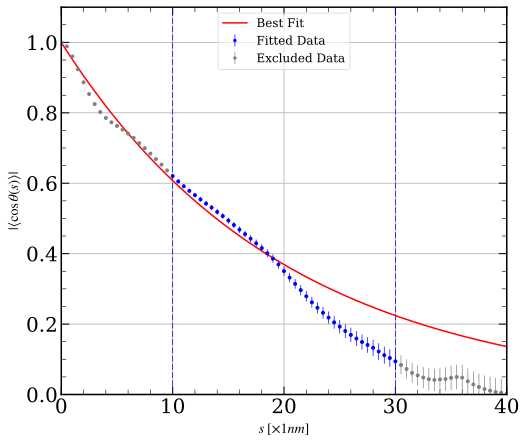

In [16]:
# Calculate the persistence length of the particles.
L_min = 10
L_max = 30
polydat.calc_tantan_lp(min_fitting_length = L_min, max_fitting_length = L_max)

# Print a summary of the polydat object.
polydat.print_summary()

tantan_correlation_fig2, ax = plt.subplots(figsize = (8,7))
# Plot the mean tangent-tangent correlation function.
polydat.plot_mean_tantan_correlations(ax = ax, error_bars = True,
                                          inc_kwargs = {'color': 'Blue', 'fmt': '.', 'ecolor': 'Blue', 'lw': 0.7, 'label': 'Fitted Data'},
                                          exc_kwargs = {'color': 'Gray', 'fmt': '.', 'ecolor': 'Gray', 'lw': 0.7, 'label': 'Excluded Data'},
                                          vline_kwargs = {'color': 'Blue', 'lw': 0.75, 'dashes': [8,3]})
# Plot the fitted decaying exponential.
polydat.plot_mean_tantan_correlations_fit(ax = ax,show_init = False,
                                              fit_kwargs = {'color': 'Red', 'lw': 1.5, 'label': 'Best Fit'},
                                              init_kwargs = {'color': 'Red', 'lw': 0.75, 'linestyle': '--', 'label': 'Initial Guess'})

# Set the title of the plot.
# ax.set_title('Mean Tangent-Tangent Correlation')

# Set the axis labels.
ax.set_xlabel(rf'$s\;[\times{polydat.resolution:.0f} nm]$',fontsize=14)
ax.set_ylabel(r'$|\langle\cos\theta(s)\rangle|$',fontsize=14)

# Set legend
ax.legend(markerscale=0.8,fontsize=12)

# Set the axis limits.
ax.set_xlim(0,40)
ax.set_ylim(0,1.1)
# Turn the grid on.
ax.grid()
# Display the plot.
plt.show()

### Tangent-Tangent Correlation

Below is an example of the end-to-end workflow for processing a set of polymer images for all classification types using the Tangent-Tangent Correlation Method.

Polymer Data Summary
----------------------------------------------------------------
Image Summary:
Number of Images:			2
Base Resolution:			2.0 nm/pixel
Upscaled:				True
Magnification Factor:			2.0
Interploation Order:			3
Upscaled Resolution:			1.0 nm/pixel
----------------------------------------------------------------
Segmentation/Classification Summary:
All Particles:				615
Linear Particles:			376
Branched Particles:			141
Branched-Looped Particles:		88
Looped Particles:			1
Overlapped Particles:			1
Unknown Particles:			0
----------------------------------------------------------------
Persistence Length Summary:
Included Classifications:		All
Minimum Fitting Contour Length:		10.0 nm
Maximum Fitting Contour Length:		30.0 nm
Tan-Tan Correlation lp:			13.6 +/- 0.1 nm
Tan-Tan Correlation Reduced Chi^2:	14.53


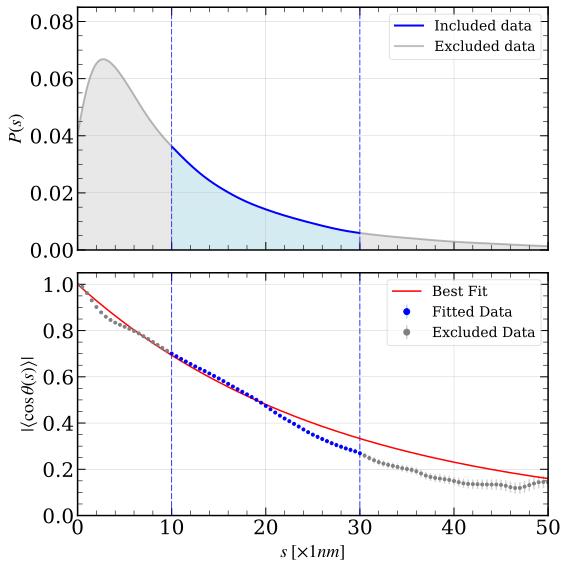

<IPython.core.display.Math object>

--------------------------------


<IPython.core.display.Math object>

In [17]:
# Create a list of the files to be analyzed.
filepaths = ['example_images/exampleCL0.png', 'example_images/exampleCL1.png']

# Create an instance of the Polydat class from the list of file paths.
polydat = PsPolypy.Polymer.Polydat.from_images(filepaths = filepaths, resolution = 2)

# Upscale the image by a factor of 2 using bi-cubic interpolation.
polydat.upscale(magnification = 2, order = 3)

# Segment the particles in the image.
polydat.segment_particles()

# Skeletonize the particles.
polydat.skeletonize_particles()

# Classify the particles.
polydat.classify_particles()

# Interpolate the skeletons of the particles.
polydat.interpolate_skeletons(step_size = 0.5, k = 3, s = .5)

# Calculate the tangent-tangent correlation for the particles.
polydat.calc_tantan_correlations()

# Calculate the persistence length.
L_min = 10
L_max = 30
polydat.calc_tantan_lp(lp_init = 11, min_fitting_length = L_min, max_fitting_length = L_max, scale_covar = True)

# Print a summary of the polydat object.
polydat.print_summary()

# Create a figure containing the complete workflow plots.
fig_ttc, ax = plt.subplots(2,1, figsize = (8,8),sharex=True)
    
# Plot contour length distribution
polydat.plot_subpath_contour_distribution(ax = ax[0], n_points = 1000,
                                  inc_dist_kwargs = {'color': 'Blue', 'lw': 2, 'label': 'Included data'},
                                  inc_fill_kwargs = {'color': 'LightBlue', 'alpha': 0.5},
                                  exc_dist_kwargs = {'color': 'Gray', 'lw': 2, 'alpha': 0.5, 'label': 'Excluded data'},
                                  exc_fill_kwargs = {'color': 'LightGray', 'alpha': 0.5},
                                  vline_kwargs = {'color': 'Blue', 'lw': 0.7, 'dashes': [8,3]})

ax[0].set_ylabel(r'$P(s)$',fontsize=18)
ax[0].set_xlim([0,60])
ax[0].set_ylim([0,0.085])
ax[0].grid(lw=0.3)
ax[0].legend(fontsize = 14)

# Plot tangent-tangent correlation with the fit.
polydat.plot_mean_tantan_correlations(error_bars = True, ax = ax[1],
                                     inc_kwargs = {'color': 'Blue', 'fmt': '.', 'ecolor': 'LightBlue', 'label': 'Fitted Data'},
                                     exc_kwargs = {'color': 'Gray', 'fmt': '.', 'ecolor': 'LightGray', 'label': 'Excluded Data'})
polydat.plot_mean_tantan_correlations_fit(ax = ax[1],
                                         fit_kwargs = {'color': 'Red', 'lw': 1.5, 'label': 'Best Fit'},
                                         init_kwargs = {'color': 'Red', 'lw': 0.75, 'linestyle': '--', 'label': 'Initial Guess'})

ax[1].set_xlabel(rf'$s\;[\times{polydat.resolution:.0f} nm]$',fontsize=18)
ax[1].set_ylabel(r'$|\langle\cos\theta(s)\rangle|$',fontsize=18)
ax[1].set_xlim([0,50])
ax[1].set_ylim(0,1.05)
ax[1].grid(lw=0.3)
ax[1].legend(fontsize=14)

# Display the plot.
plt.tight_layout()
plt.show()
# Show the fitting results.
# polydat.tantan_fit_result


# Extract best-fit parameter and its standard deviation
result = polydat.tantan_fit_result
lp_0 = result.params['lp'].value
std_0 = result.params['lp'].stderr

# Goodness-of-fit measure (reduced chi-squared)
rchi2_0 = result.redchi  # Reduced chi-squared

# Scale the standard deviation only if reduced chi-squared is greater than 1
if rchi2_0 > 1.0:
    scaled_std_r2 = np.sqrt(rchi2_0) * std_0
else:
    scaled_std_r2 = std_0

# Display results
display(Math(rf"$\chi_{{red}}^2 = {rchi2_0:.2f}$"))
print('-' * 32)
display(Math(rf"$l_p = {lp_0:.1f} \pm {scaled_std_r2:.1f}$"))

result

### $\langle R^2\rangle$ - Mean Square End-To-End Distance

The above workflow can be performed to calculate the Mean Squared End-To-End distance and fit. Simply replace ```calc_tantan_correlations``` and ```calc_tantan_lp``` with ```calc_displacements``` and ```calc_R2_lp``` respectively. Below is an example of the end-to-end workflow for processing a set of polymer images for only linear particles using the Mean Squared End to End Distance Method.

Polymer Data Summary
----------------------------------------------------------------
Image Summary:
Number of Images:			2
Base Resolution:			2.0 nm/pixel
Upscaled:				True
Magnification Factor:			2.0
Interploation Order:			3
Upscaled Resolution:			1.0 nm/pixel
----------------------------------------------------------------
Segmentation/Classification Summary:
All Particles:				615
Linear Particles:			376
Branched Particles:			141	(Filtered Out)
Branched-Looped Particles:		88	(Filtered Out)
Looped Particles:			1	(Filtered Out)
Overlapped Particles:			1	(Filtered Out)
Unknown Particles:			0	(Filtered Out)
----------------------------------------------------------------
Persistence Length Summary:
Included Classifications:		['Linear']
Minimum Fitting Contour Length:		10.0 nm
Maximum Fitting Contour Length:		40.0 nm
R^2 lp:					12.6 +/- 0.2 nm
R^2 Reduced Chi^2:			49.04


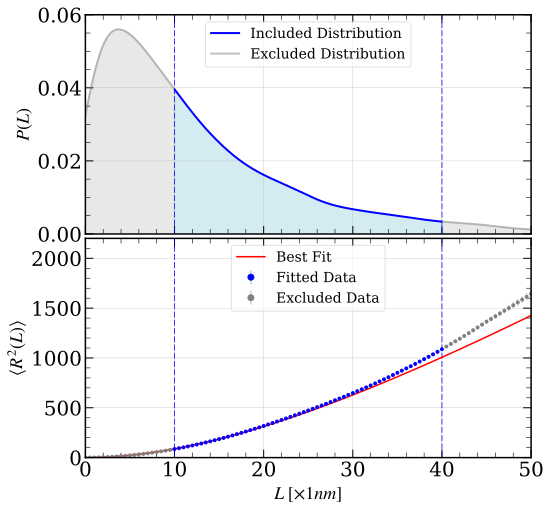

<IPython.core.display.Math object>

--------------------------------


<IPython.core.display.Math object>

In [18]:
# Create a list of the files to be analyzed.
filepaths = ['example_images/exampleCL0.png', 'example_images/exampleCL1.png']

# Create an instance of the Polydat class from the list of file paths.
polydat = PsPolypy.Polymer.Polydat.from_images(filepaths = filepaths, resolution = 2)

# Upscale the image by a factor of 2 using bi-cubic interpolation.
polydat.upscale(magnification = 2, order = 3)

# Segment the particles in the image.
polydat.segment_particles()

# Skeletonize the particles.
polydat.skeletonize_particles()

# Classify the particles.
polydat.classify_particles()

# Filter the particles to only include the Linear classification.
polydat.filter_particles(classifications = ['Linear'])

# Interpolate the skeletons of the particles.
polydat.interpolate_skeletons(step_size = 0.5, k = 3, s = .5)

# Calculate <R^2>
polydat.calc_displacements()

L_min = 10
L_max = 40
# Calculate the persistence length.
polydat.calc_R2_lp(lp_init = 11, min_fitting_length = L_min, max_fitting_length = L_max, scale_covar = True)

# Print a summary of the polydat object.
polydat.print_summary()

# Create a figure containing the complete workflow plots.
fig_R2, ax = plt.subplots(2,1, figsize = (8,8),sharex=True)

# Plot contour length distribution
ax[0] = polydat.plot_subpath_contour_distribution(ax = ax[0], n_points = 1000,
                                          inc_dist_kwargs = {'color': 'Blue', 'lw': 2, 'label': 'Included Distribution'},
                                          inc_fill_kwargs = {'color': 'LightBlue', 'alpha': 0.5},
                                          exc_dist_kwargs = {'color': 'Gray', 'lw': 2, 'alpha': 0.5, 'label': 'Excluded Distribution'},
                                          exc_fill_kwargs = {'color': 'LightGray', 'alpha': 0.5},
                                          vline_kwargs = {'color': 'Blue', 'lw': 0.75, 'dashes': [8,3]})

ax[0].set_ylim(0,0.06)
ax[0].set_ylabel(r'$P(L)$',fontsize=18)
ax[0].grid(lw=0.3)
ax[0].legend(fontsize = 14)

# Plot tangent-tangent correlation with the fit.
polydat.plot_mean_squared_displacements(ax = ax[1], error_bars = True,
                                        inc_kwargs = {'color': 'Blue', 'fmt': '.', 'ecolor': 'LightBlue', 'label': 'Fitted Data'},
                                        exc_kwargs = {'color': 'Gray', 'fmt': '.', 'ecolor': 'LightGray', 'label': 'Excluded Data'})
polydat.plot_mean_squared_displacements_fit(ax = ax[1], show_init = False,
                                            fit_kwargs = {'color': 'Red', 'lw': 1.5, 'label': 'Best Fit'},
                                            init_kwargs = {'color': 'Red', 'lw': 0.75, 'linestyle': '--', 'label': 'Initial Guess'})
ax[1].set_xlim([0,50])
ax[1].set_ylim(0,2200)
ax[1].set_xlabel(rf'$L\;[\times{polydat.resolution:.0f} nm]$',fontsize=18)
ax[1].set_ylabel(r'$\langle R^2(L)\rangle$',fontsize=18)


ax[1].grid(lw=0.3)
ax[1].legend(fontsize = 14)

# Display the plot.
plt.show()
# Show the fitting results.
# polydat.wlc_fit_result


# Extract best-fit parameter and its standard deviation
result = polydat.R2_fit_result
lp_0 = result.params['lp'].value
std_0 = result.params['lp'].stderr

# Goodness-of-fit measure (reduced chi-squared)
rchi2_0 = result.redchi  # Reduced chi-squared

# Scale the standard deviation only if reduced chi-squared is greater than 1
if rchi2_0 > 1.0:
    scaled_std_r2 = np.sqrt(rchi2_0) * std_0
else:
    scaled_std_r2 = std_0

# Display results
display(Math(rf"$\chi_{{red}}^2 = {rchi2_0:.2f}$"))
print('-' * 32)
display(Math(rf"$l_p = {lp_0:.1f} \pm {scaled_std_r2:.1f}$"))

result

## Versions of used packages 

In [19]:
%load_ext watermark
%watermark --python --packages numpy,scipy,networkx,skan,matplotlib,PIL,skimage,lmfit

Python implementation: CPython
Python version       : 3.12.8
IPython version      : 8.30.0

numpy     : 2.0.2
scipy     : 1.14.1
networkx  : 3.4.2
skan      : 0.12.1
matplotlib: 3.9.4
PIL       : 11.0.0
skimage   : 0.24.0
lmfit     : 1.3.2

